In [50]:
# Importing required libraries

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing
import librosa
import IPython.display as ipd

# File system operations
import os

## **Importing and playing a first audio file**

In [51]:
audio_path = '../data/raw/genres_original/reggae/reggae.00000.wav'
# sr=None to preserve the native sampling rate
array, sampling_rate = librosa.load(audio_path, sr=None)

print(f'x: {array.shape}', f'sample rate: {sampling_rate}', sep='\n')

x: (661794,)
sample rate: 22050


This returns an audio time series as a numpy array with a default **sampling rate(sr)** of 22KHZ mono. The sampling rate (also called sampling frequency) is the *number of samples taken in one second* and is measured in hertz (Hz).

The audible frequencies in human speech are below 8 kHz and therefore sampling speech at 16 kHz is sufficient (Nyquist). Using a higher sampling rate will not capture more information and merely leads to an increase in the computational cost of processing such files.

In [52]:
array, sampling_rate = librosa.load(audio_path, sr=16000)

print(f'x: {array.shape}', f'sample rate: {sampling_rate}', sep='\n')

x: (480214,)
sample rate: 16000


The **amplitude of a sound** describes the *sound pressure level at any given instant* and is measured in decibels (dB). In digital audio, each audio sample records the amplitude of the audio wave at a point in time. 

Also, the **bit depth** of the sample determines with how much *precision* this amplitude value can be described. The higher the bit depth, the more faithfully the digital representation approximates the original continuous sound wave.

In [53]:
print('Amplitude sample:', array[:5])

print('bit depth:', array.dtype)

Amplitude sample: [0.00518333 0.01790155 0.07761538 0.12327619 0.07922523]
bit depth: float32


Each is a binary term, representing the number of possible steps to which the amplitude value can be quantized when it’s converted from continuous to discrete. For the given 32bit depth we can achieve an incredible 4,294,967,296 steps.

Because quantizing involves rounding off the continuous value to a discrete value, the *sampling process introduces noise*. The *higher the bit depth, the smaller this quantization noise*. 

In practice, the quantization noise of 16-bit audio is already small enough to be inaudible, and using higher bit depths is generally not necessary.

In [54]:
# To display and listen the audio file we use the ipd.Audio widget
ipd.Audio(audio_path)

## **Audio Visualization**

Just as with continuous audio signals, the amplitude of digital audio is typically expressed in decibels (dB). Since human hearing is logarithmic in nature — our ears are more sensitive to small fluctuations in quiet sounds than in loud sounds — the loudness of a sound is easier to interpret if the amplitudes are in decibels, which are also logarithmic.

The decibel scale for real-world audio starts at 0 dB, which represents the quietest possible sound humans can hear, and louder sounds have larger values. However, for digital audio signals, 0 dB is the loudest possible amplitude, while all other amplitudes are negative. As a quick rule of thumb: every -6 dB is a halving of the amplitude, and anything below -60 dB is generally inaudible unless you really crank up the volume.

### **Waveform**

A **Waveform** plots the sample values over time and illustrates the changes in the sound’s amplitude. This is also known as the *time domain representation of sound*.  It's commonly used to find similarities or differences between audio signals.

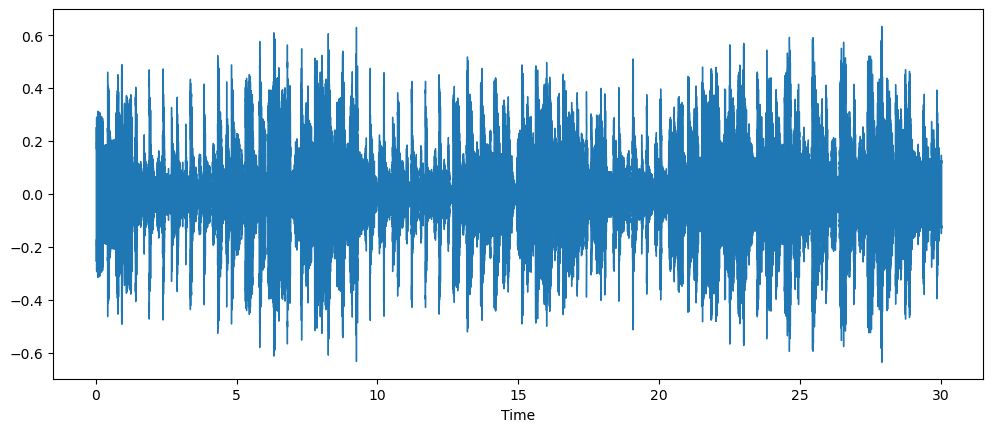

In [55]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

This plots the **amplitude** of the signal on the **y-axis** and **time** along the **x-axis**. In other words, each point corresponds to a single sample value that was taken when this sound was sampled.

Also note that librosa returns the audio as floating-point values already, and that the amplitude values are indeed within the [-1.0, 1.0] range.

### **Frequency Spectrum**

The **frequency spectrum** of an audio signal is a visual representation of the *frequencies that make up the sound*. It shows the amplitude (or intensity) of each frequency component present in the signal.

To compute the spectrum we must first calculate the **Discrete Fourier Transform** (DFT). It transforms a time-domain signal into a *frequency-domain representation*. The output of the DFT represents the *amplitude and phase of the different frequency components present in the original signal*.

In [63]:
samples = array[:4000]
# Using the numpy Fast Fourier Transform (fft) algorithm
fft_result = np.fft.rfft(samples) # FFT for real-valued signals

# Extracting the magnitude in dB
mag = librosa.amplitude_to_db(np.abs(fft_result), ref=np.max) # ref -> to normalize the dB values relative to the loudest part of the signal

# Calculating the phase axis
freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(samples)) # better than np.fft.fftfreq for audio-specific analysis

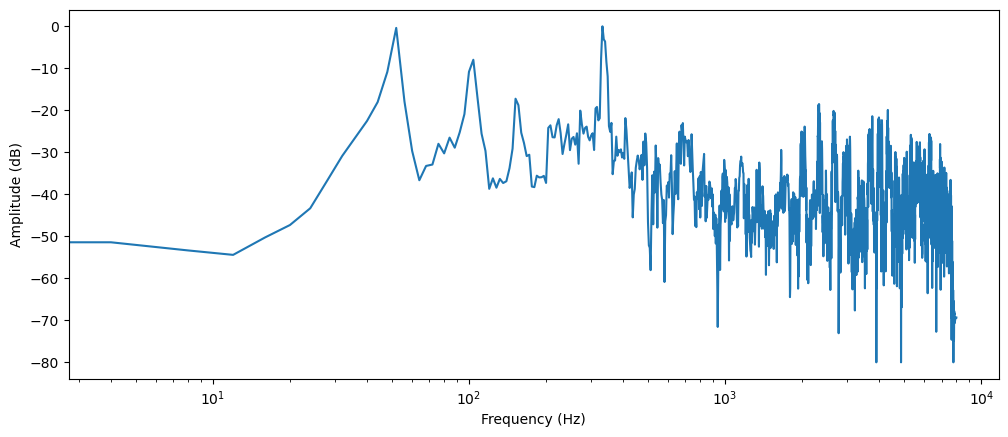

In [64]:
plt.figure().set_figwidth(12)
plt.plot(freq, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

To reduce the **spectral leakage** phenomenon (spreading of a signal's energy from its true frequency to neighboring frequencies in the spectrum) we will use a window function known as the **Hanning window**. This phenomenon can be caused by the abrupt beginning and end of the signal, or non-analysis frequencies.

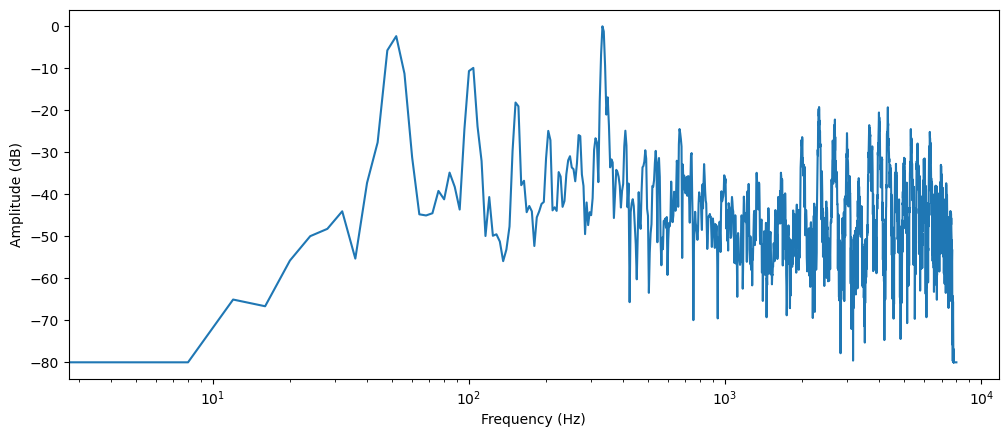

In [65]:
# Hanning window
window = np.hanning(len(samples))
windowed_input = samples * window

fft_result = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
mag = librosa.amplitude_to_db(np.abs(fft_result), ref=np.max)

# get the frequency bins
freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(samples))

plt.figure().set_figwidth(12)
plt.plot(freq, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

The frequency spectrum of an audio signal contains the exact same information as its waveform — they are simply two different ways of looking at the same data. Where the **waveform plots the amplitude of the audio signal over time, the spectrum visualizes the amplitudes of the individual frequencies at a fixed point in time**.

### **Spectogram**

A **Spectrogram** is a 2D plot that shows how the **frequency content of a signal changes over time**. It takes multiple DFTs, each covering only a small slice of time, and stack the resulting spectra together into the plot

It's a valuable tool for analyzing audio signals, especially for identifying patterns, frequencies, and time-varying characteristics.

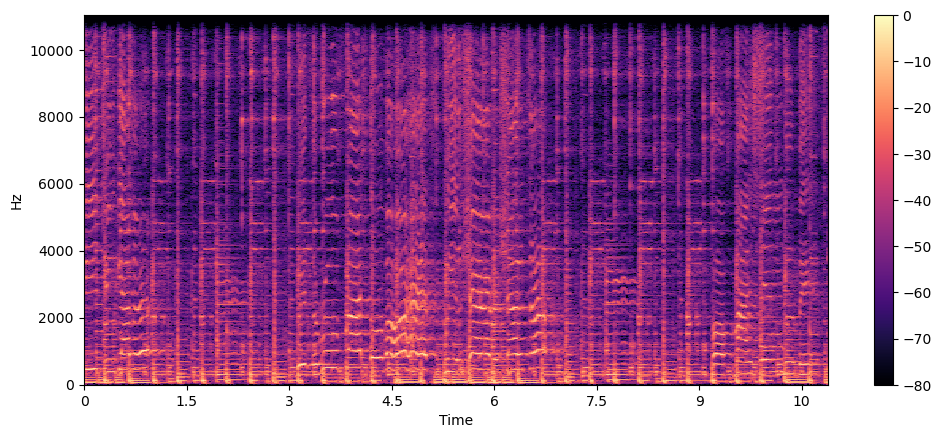

In [71]:
D = librosa.stft(array[:len(array)//2])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

Each vertical slice in the spectogram corresponds to a single frequency spectrum, seen from the top. Where:

-   X-axis: Represents time, often in seconds.
-   Y-axis: Represents frequency, usually in Hertz (Hz).
-   Color/intensity: Represents the amplitude (dB) or intensity of the frequency component at a given time.

### **Mel Spectogram**

A *Mel spectrogram* is a modification of the traditional spectrogram that is designed to **better reflect human hearing** perception. Mel-scale frequencies are *based on a logarithmic scale that approximates how humans perceive pitch*. This makes mel spectrograms more suitable for tasks that involve human auditory perception, such as speech recognition and music analysis.

In order to create a mel spectogram the SFT is used as before, however, each spectrum is then sent through a set of filters (mel filterbank), to transform the frequencies to the mel scale.

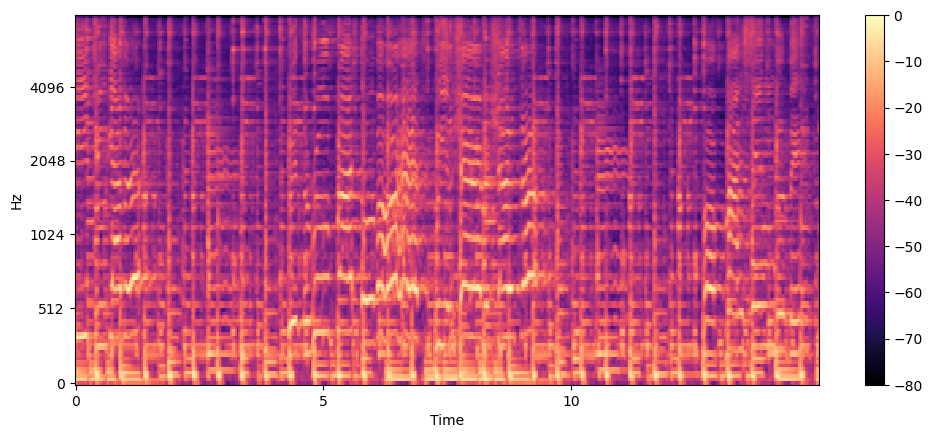

In [73]:
S = librosa.feature.melspectrogram(y=array[:len(array)//2], sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In this mel spectrogram, the vertical stripes represent different notes or chords, and the horizontal bands indicate the frequency range in the mel scale.